# Session4: Decision Trees and Random Forests

## Session Overview

In this tutorial, we'll explore two powerful tree-based machine learning algorithms and learn how to evaluate multi-class classification problems. Today's learning objectives are:

**Learning Objectives:**
- Understand the mathematical foundations of decision trees (entropy, information gain, Gini impurity)
- Learn how decision trees make splitting decisions and build classification rules
- Explore random forests as an ensemble method that improves upon single decision trees
- Extend classification metrics from binary to multi-class problems
- Apply these concepts to EEG signal classification tasks

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Generating Synthetic EEG Data

Before we dive into the algorithms, let's create a synthetic EEG dataset. We'll simulate band power features from different EEG frequency bands that might correspond to different mental states. This synthetic data allows us to focus on understanding the machine learning concepts without getting distracted by signal processing details.

We'll classify four different mental states: **Focused**, **Relaxed**, **Drowsy**, and **Active**.

In [2]:
def generate_synthetic_eeg_data(n_samples=800):
    """
    Generate synthetic EEG band power features for different mental states.

    Parameters:
    -----------
    n_samples : int
        Total number of samples to generate (will be split equally among classes)

    Returns:
    --------
    X : numpy array
        Feature matrix with shape (n_samples, 5) representing band powers
    y : numpy array
        Labels array with shape (n_samples,)
    """

    samples_per_class = n_samples // 4

    # Focused state: High beta and gamma, low delta and theta
    focused_delta = np.random.normal(2, 0.5, samples_per_class)
    focused_theta = np.random.normal(3, 0.6, samples_per_class)
    focused_alpha = np.random.normal(5, 0.8, samples_per_class)
    focused_beta = np.random.normal(12, 1.5, samples_per_class)
    focused_gamma = np.random.normal(8, 1.0, samples_per_class)
    focused_data = np.column_stack([focused_delta, focused_theta, focused_alpha,
                                    focused_beta, focused_gamma])
    focused_labels = np.zeros(samples_per_class)  # Class 0: Focused

    # Relaxed state: High alpha, moderate beta, low gamma
    relaxed_delta = np.random.normal(4, 0.7, samples_per_class)
    relaxed_theta = np.random.normal(5, 0.8, samples_per_class)
    relaxed_alpha = np.random.normal(12, 1.5, samples_per_class)
    relaxed_beta = np.random.normal(6, 1.0, samples_per_class)
    relaxed_gamma = np.random.normal(3, 0.6, samples_per_class)
    relaxed_data = np.column_stack([relaxed_delta, relaxed_theta, relaxed_alpha,
                                    relaxed_beta, relaxed_gamma])
    relaxed_labels = np.ones(samples_per_class)  # Class 1: Relaxed

    # Drowsy state: High delta and theta, low beta and gamma
    drowsy_delta = np.random.normal(10, 1.5, samples_per_class)
    drowsy_theta = np.random.normal(9, 1.2, samples_per_class)
    drowsy_alpha = np.random.normal(6, 1.0, samples_per_class)
    drowsy_beta = np.random.normal(3, 0.7, samples_per_class)
    drowsy_gamma = np.random.normal(2, 0.5, samples_per_class)
    drowsy_data = np.column_stack([drowsy_delta, drowsy_theta, drowsy_alpha,
                                   drowsy_beta, drowsy_gamma])
    drowsy_labels = np.full(samples_per_class, 2)  # Class 2: Drowsy

    # Active state: Moderate-to-high across all bands
    active_delta = np.random.normal(5, 1.0, samples_per_class)
    active_theta = np.random.normal(6, 1.0, samples_per_class)
    active_alpha = np.random.normal(8, 1.2, samples_per_class)
    active_beta = np.random.normal(10, 1.5, samples_per_class)
    active_gamma = np.random.normal(6, 1.0, samples_per_class)
    active_data = np.column_stack([active_delta, active_theta, active_alpha,
                                   active_beta, active_gamma])
    active_labels = np.full(samples_per_class, 3)  # Class 3: Active

    # Combine all data
    X = np.vstack([focused_data, relaxed_data, drowsy_data, active_data])
    y = np.hstack([focused_labels, relaxed_labels, drowsy_labels, active_labels])

    # Shuffle the data
    shuffle_idx = np.random.permutation(len(y))
    X = X[shuffle_idx]
    y = y[shuffle_idx]

    return X, y

# Generate our synthetic dataset
X, y = generate_synthetic_eeg_data(n_samples=800)

# Create feature names for better readability
feature_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
class_names = ['Focused', 'Relaxed', 'Drowsy', 'Active']

# Convert to DataFrame for easier visualization
df = pd.DataFrame(X, columns=feature_names)
df['Mental_State'] = [class_names[int(label)] for label in y]

print("Dataset shape:", X.shape)
print("\nFirst few samples:")
print(df.head(10))
print("\nClass distribution:")
print(df['Mental_State'].value_counts())

Dataset shape: (800, 5)

First few samples:
       Delta     Theta      Alpha       Beta     Gamma Mental_State
0   4.663745  5.266844   7.034040  10.319110  5.537060       Active
1   2.116127  2.904037   5.203537  13.580463  9.443765      Focused
2  10.398044  9.816259   6.869156   3.324244  2.204304       Drowsy
3   3.740570  4.955385  13.009772   7.139879  3.156193      Relaxed
4   4.224950  6.224601  12.211329   5.776534  2.262270      Relaxed
5   5.455904  4.312656   7.091883   9.983362  7.890441       Active
6   4.698607  4.465528  13.167542   6.350630  3.418173      Relaxed
7   3.682868  7.450928   8.384943   8.826995  6.347562       Active
8   9.729412  9.412545   5.946879   2.157759  2.366246       Drowsy
9   5.388979  5.638537   8.521724  11.518956  4.500984       Active

Class distribution:
Mental_State
Active     200
Focused    200
Drowsy     200
Relaxed    200
Name: count, dtype: int64


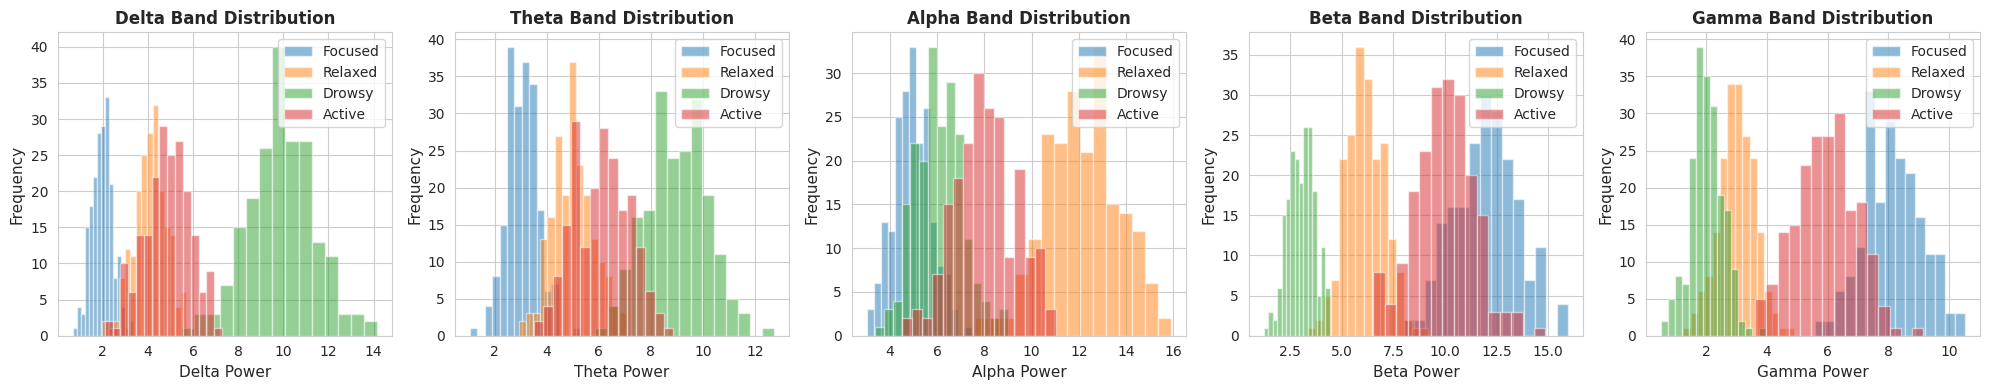

Notice how different mental states have characteristic patterns in different frequency bands!


In [3]:
# Visualize the distribution of band powers for different mental states
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, feature in enumerate(feature_names):
    for class_name in class_names:
        class_data = df[df['Mental_State'] == class_name][feature]
        axes[idx].hist(class_data, alpha=0.5, label=class_name, bins=15)

    axes[idx].set_xlabel(f'{feature} Power', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{feature} Band Distribution', fontsize=12, fontweight='bold')
    axes[idx].legend()

plt.tight_layout()
plt.show()

print("Notice how different mental states have characteristic patterns in different frequency bands!")

## 2. Decision Trees: Mathematical Foundation

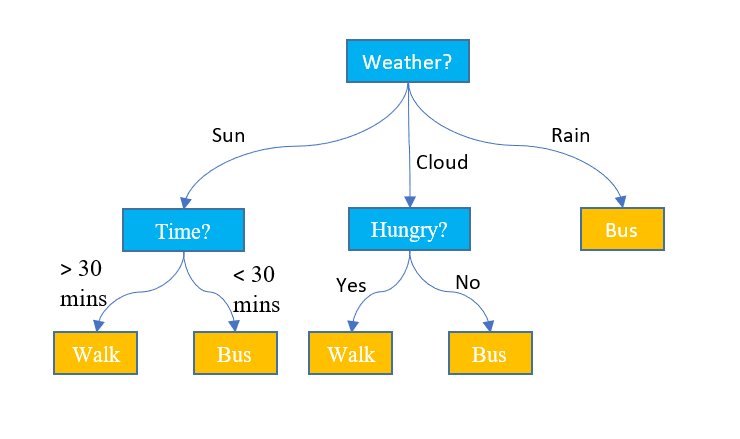

Now let's understand how decision trees work. A decision tree is a flowchart-like structure where each internal node represents a test on a feature, each branch represents the outcome of that test, and each leaf node represents a class label.

### 2.1 How Decision Trees Make Decisions

The key question is: **How does the tree decide where to split the data?** The answer lies in measuring the impurity or disorder of the data.

### 2.2 Entropy and Information Gain

**Entropy** is a measure of disorder or uncertainty in the data. For a dataset with $c$ classes, entropy is defined as:

$$H(S) = -\sum_{i=1}^{c} p_i \log_2(p_i)$$

where $p_i$ is the proportion of samples belonging to class $i$.

**Properties of Entropy:**
- Entropy is 0 when all samples belong to one class (perfect purity)
- Entropy is maximum when classes are equally distributed (maximum disorder)
- For binary classification: maximum entropy is 1
- For 4-class problem like ours: maximum entropy is 2

**Information Gain** measures how much entropy is reduced by splitting on a particular feature:

$$IG(S, A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} H(S_v)$$

where $S$ is the dataset, $A$ is the feature we're considering for splitting, and $S_v$ is the subset of $S$ where feature $A$ has value $v$.

The tree chooses the split that maximizes information gain.

### 2.3 Gini Impurity (Alternative Metric)

Another popular impurity measure is the **Gini Impurity**:

$$Gini(S) = 1 - \sum_{i=1}^{c} p_i^2$$

**Properties of Gini Impurity:**
- Gini is 0 when all samples belong to one class
- Gini is maximum when classes are equally distributed
- Computationally faster than entropy (no logarithm calculation)
- In practice, Gini and Entropy often give similar results

Let's implement these measures to understand them better.

In [4]:
def calculate_entropy(y):
    """
    Calculate the entropy of a label array.

    Parameters:
    -----------
    y : numpy array
        Array of class labels

    Returns:
    --------
    float : entropy value
    """
    # Get the proportion of each class
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)

    # Calculate entropy (avoid log(0) by filtering out zero probabilities)
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    return entropy

def calculate_gini(y):
    """
    Calculate the Gini impurity of a label array.

    Parameters:
    -----------
    y : numpy array
        Array of class labels

    Returns:
    --------
    float : Gini impurity value
    """
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)

    # Calculate Gini impurity
    gini = 1 - np.sum(probabilities ** 2)

    return gini

# Let's calculate these measures for our entire dataset
print("=" * 60)
print("IMPURITY MEASURES FOR OUR DATASET")
print("=" * 60)

# Calculate for the full dataset
entropy_full = calculate_entropy(y)
gini_full = calculate_gini(y)

print(f"\nFull dataset (balanced 4 classes):")
print(f"  Entropy: {entropy_full:.4f} (max for 4 classes is {np.log2(4):.4f})")
print(f"  Gini Impurity: {gini_full:.4f} (max for 4 classes is {1 - 1/4:.4f})")

# Calculate for a pure subset (only one class)
pure_subset = y[y == 0]
entropy_pure = calculate_entropy(pure_subset)
gini_pure = calculate_gini(pure_subset)

print(f"\nPure subset (only one class):")
print(f"  Entropy: {entropy_pure:.4f} (minimum is 0)")
print(f"  Gini Impurity: {gini_pure:.4f} (minimum is 0)")

# Calculate for an imbalanced subset
imbalanced_subset = np.hstack([y[y == 0][:150], y[y == 1][:50]])
entropy_imbalanced = calculate_entropy(imbalanced_subset)
gini_imbalanced = calculate_gini(imbalanced_subset)

print(f"\nImbalanced subset (75% class 0, 25% class 1):")
print(f"  Entropy: {entropy_imbalanced:.4f}")
print(f"  Gini Impurity: {gini_imbalanced:.4f}")

print("\n" + "="*60)
print("Key insight: Lower values = more pure/organized data")
print("Decision trees try to create splits that minimize these measures!")
print("="*60)

IMPURITY MEASURES FOR OUR DATASET

Full dataset (balanced 4 classes):
  Entropy: 2.0000 (max for 4 classes is 2.0000)
  Gini Impurity: 0.7500 (max for 4 classes is 0.7500)

Pure subset (only one class):
  Entropy: -0.0000 (minimum is 0)
  Gini Impurity: 0.0000 (minimum is 0)

Imbalanced subset (75% class 0, 25% class 1):
  Entropy: 0.8113
  Gini Impurity: 0.3750

Key insight: Lower values = more pure/organized data
Decision trees try to create splits that minimize these measures!


## 3. Building a Decision Tree Classifier

Now let's build our first decision tree. The algorithm works as follows:

1. **Start with the entire dataset** at the root node
2. **For each feature**, calculate the information gain (or Gini decrease) from splitting on that feature
3. **Choose the feature** that gives the maximum information gain
4. **Split the data** based on that feature
5. **Recursively repeat** steps 2-4 for each child node
6. **Stop splitting** when:
   - All samples in a node belong to the same class
   - Maximum depth is reached
   - Minimum samples per leaf is reached
   - No more features to split on

Let's split our data and train a decision tree.

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])
print("\nTraining set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for class_idx, count in zip(unique, counts):
    print(f"  {class_names[int(class_idx)]}: {count} samples")

Training set size: 640
Testing set size: 160

Training set class distribution:
  Focused: 160 samples
  Relaxed: 160 samples
  Drowsy: 160 samples
  Active: 160 samples


In [17]:
# Create and train a decision tree
# We'll limit the depth to make it more interpretable
dt_classifier = DecisionTreeClassifier(
    criterion='gini',        # Can also use 'entropy'
    max_depth=4,            # Limit tree depth for interpretability
    min_samples_split=20,   # Minimum samples required to split a node
    min_samples_leaf=10,    # Minimum samples required in a leaf node
    random_state=42
)

# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

# Calculate basic accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Decision Tree Performance:")
print(f"  Training Accuracy: {train_accuracy:.4f}")
print(f"  Testing Accuracy: {test_accuracy:.4f}")
print(f"\nThe difference between training and testing accuracy: {train_accuracy - test_accuracy:.4f}")
print("A small difference suggests good generalization!")

Decision Tree Performance:
  Training Accuracy: 0.9797
  Testing Accuracy: 0.9625

The difference between training and testing accuracy: 0.0172
A small difference suggests good generalization!


### 3.1 Visualizing the Decision Tree

One of the greatest advantages of decision trees is their interpretability. We can visualize the entire decision-making process. Each node in the tree shows:

- The feature and threshold used for splitting
- The Gini impurity at that node
- The number of samples at that node
- The distribution of classes
- The predicted class (the majority class)

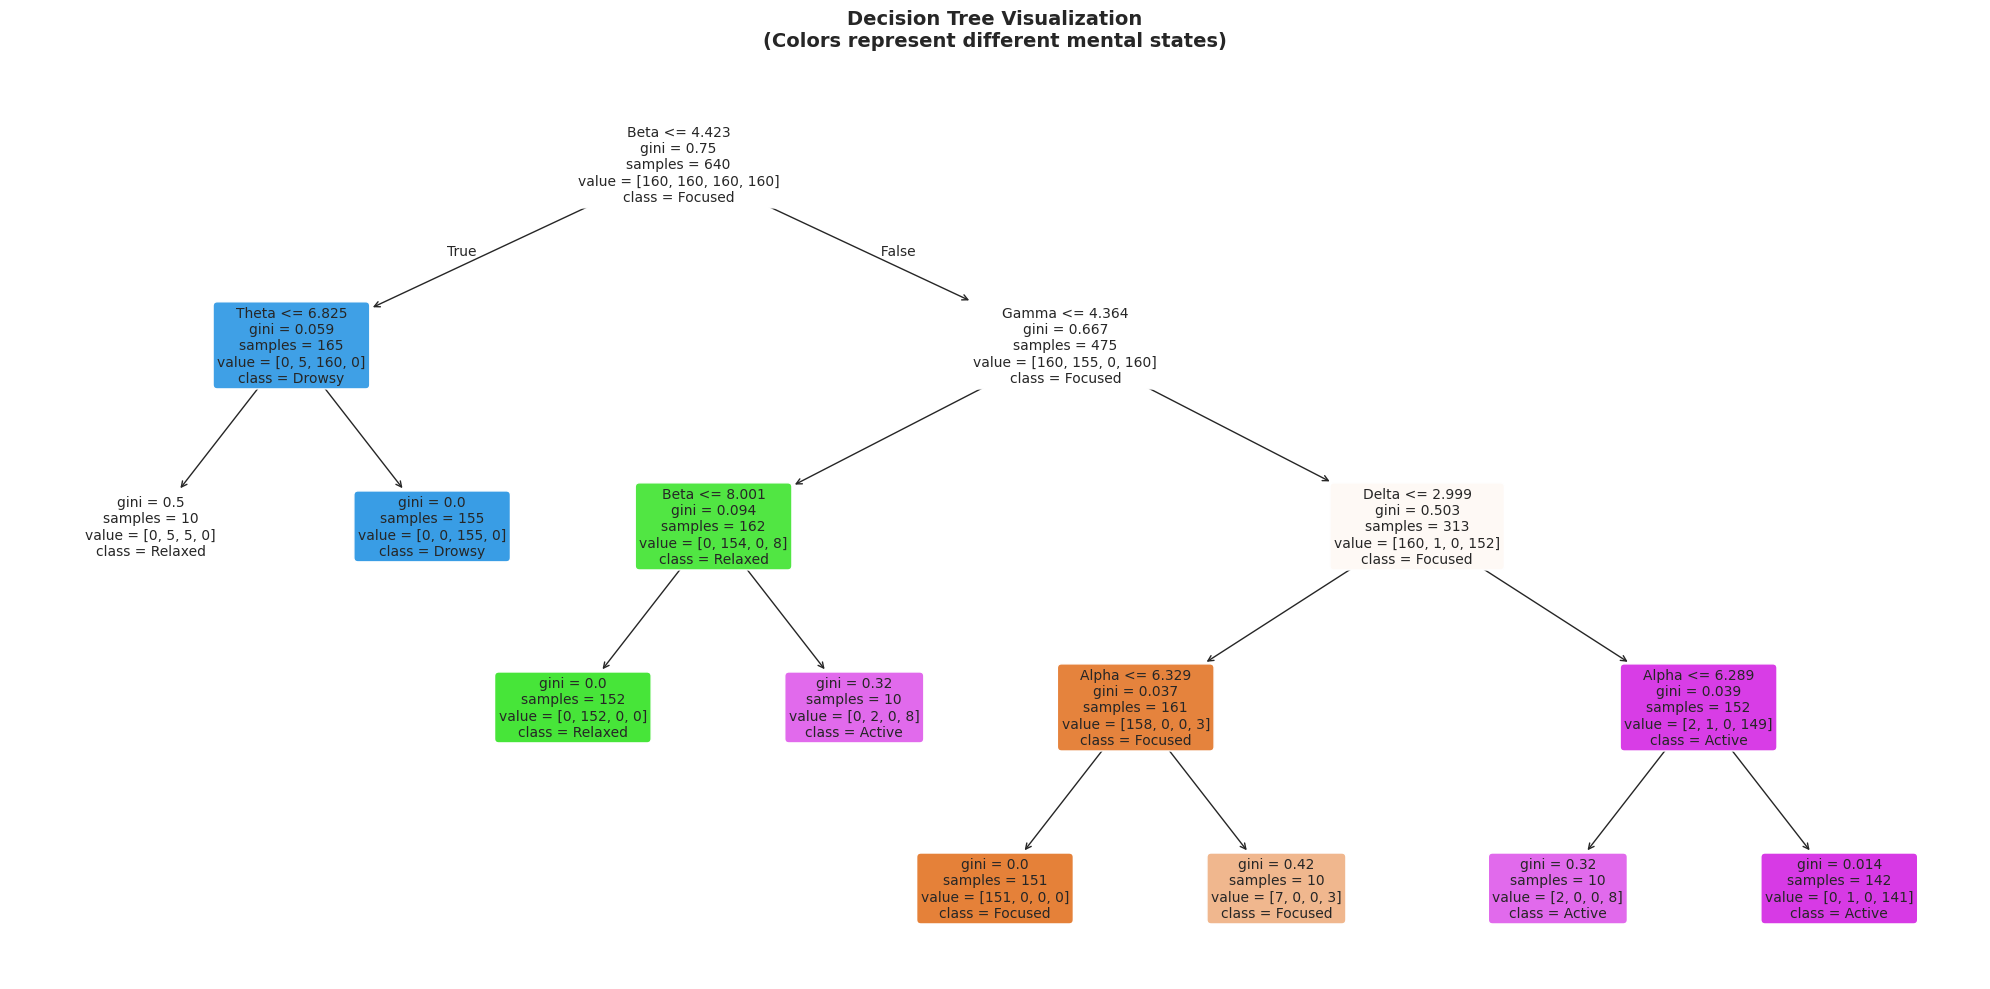


How to read this tree:
1. Start at the root (top) and follow the conditions down
2. Each box shows: feature <= threshold, gini, samples, value, class
3. 'value' shows the count of samples for each class at that node
4. Color intensity indicates class purity (darker = more pure)
5. Follow left branch if condition is True, right if False


In [7]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    dt_classifier,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization\n(Colors represent different mental states)",
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nHow to read this tree:")
print("1. Start at the root (top) and follow the conditions down")
print("2. Each box shows: feature <= threshold, gini, samples, value, class")
print("3. 'value' shows the count of samples for each class at that node")
print("4. Color intensity indicates class purity (darker = more pure)")
print("5. Follow left branch if condition is True, right if False")

### 3.2 Feature Importance

Decision trees can tell us which features are most important for making predictions. Feature importance is calculated based on how much each feature reduces impurity across all splits in the tree. Features that appear higher in the tree and reduce impurity more are considered more important.

Feature Importances:
Feature  Importance
   Beta    0.358296
  Delta    0.314863
  Gamma    0.311471
  Theta    0.010157
  Alpha    0.005212


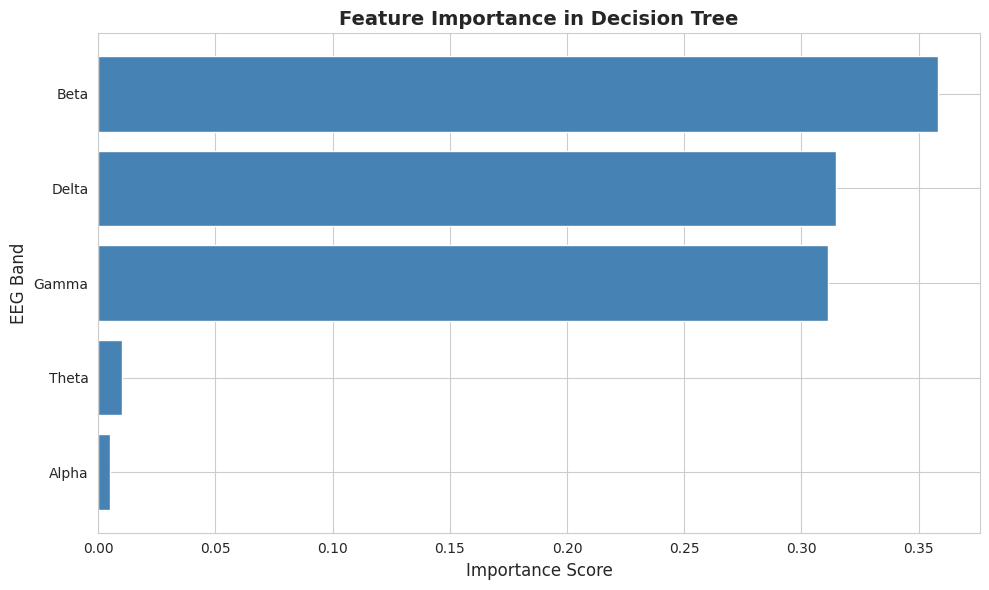


The most important feature is Beta band!


In [8]:
# Get feature importances
feature_importance = dt_classifier.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string(index=False))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('EEG Band', fontsize=12)
plt.title('Feature Importance in Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

print(f"\nThe most important feature is {importance_df.iloc[0]['Feature']} band!")


## 4. Random Forests: Ensemble Learning

While decision trees are powerful and interpretable, they have a significant weakness: they tend to overfit the training data. A tree can memorize the training examples by growing deep enough, but this leads to poor generalization on new data.

**Random Forests** solve this problem through ensemble learning. The key idea is simple but powerful: instead of relying on a single decision tree, we create many trees and let them vote on the final prediction.

### 4.1 How Random Forests Work

Random forests use two key techniques:

**1. Bootstrap Aggregating (Bagging):**
- Create multiple training datasets by randomly sampling with replacement from the original training data
- Each tree is trained on a different bootstrap sample
- This introduces diversity among the trees

**2. Random Feature Selection:**
- At each split in each tree, only consider a random subset of features
- Typically use $\sqrt{n_{features}}$ features for classification
- This further decorrelates the trees and prevents them from all making the same mistakes

**Making Predictions:**
- For classification: each tree votes, and the majority class wins

### 4.2 Why Random Forests Work Better

The mathematical insight is that if individual trees make different errors, these errors tend to cancel out in the average. This is especially effective when trees are decorrelated (which is why we use bagging and random feature selection).

In [9]:
# Create and train a random forest
rf_classifier = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    criterion='gini',        # Splitting criterion
    max_depth=10,           # Maximum depth of each tree
    min_samples_split=10,   # Minimum samples to split a node
    min_samples_leaf=5,     # Minimum samples in a leaf
    max_features='sqrt',    # Number of features to consider at each split
    bootstrap=True,         # Use bootstrap sampling
    random_state=42,
    n_jobs=-1               # Use all available processors
)

# Train the model
print("Training Random Forest with 100 trees...")
rf_classifier.fit(X_train, y_train)
print("Training complete!\n")

# Make predictions
y_train_pred_rf = rf_classifier.predict(X_train)
y_test_pred_rf = rf_classifier.predict(X_test)

# Calculate accuracy
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

print("=" * 60)
print("PERFORMANCE COMPARISON: Decision Tree vs Random Forest")
print("=" * 60)

print("\nDecision Tree:")
print(f"  Training Accuracy: {train_accuracy:.4f}")
print(f"  Testing Accuracy:  {test_accuracy:.4f}")
print(f"  Difference:        {train_accuracy - test_accuracy:.4f}")

print("\nRandom Forest:")
print(f"  Training Accuracy: {train_accuracy_rf:.4f}")
print(f"  Testing Accuracy:  {test_accuracy_rf:.4f}")
print(f"  Difference:        {train_accuracy_rf - test_accuracy_rf:.4f}")

print("\n" + "="*60)
print(f"Improvement in test accuracy: {test_accuracy_rf - test_accuracy:.4f}")
print("Random Forest typically shows better generalization!")
print("="*60)

Training Random Forest with 100 trees...
Training complete!

PERFORMANCE COMPARISON: Decision Tree vs Random Forest

Decision Tree:
  Training Accuracy: 0.9797
  Testing Accuracy:  0.9625
  Difference:        0.0172

Random Forest:
  Training Accuracy: 0.9984
  Testing Accuracy:  0.9875
  Difference:        0.0109

Improvement in test accuracy: 0.0250
Random Forest typically shows better generalization!



Feature Importance Comparison:
Feature  Decision Tree  Random Forest
  Delta       0.314863       0.307675
  Theta       0.010157       0.111847
  Alpha       0.005212       0.130254
   Beta       0.358296       0.210291
  Gamma       0.311471       0.239933


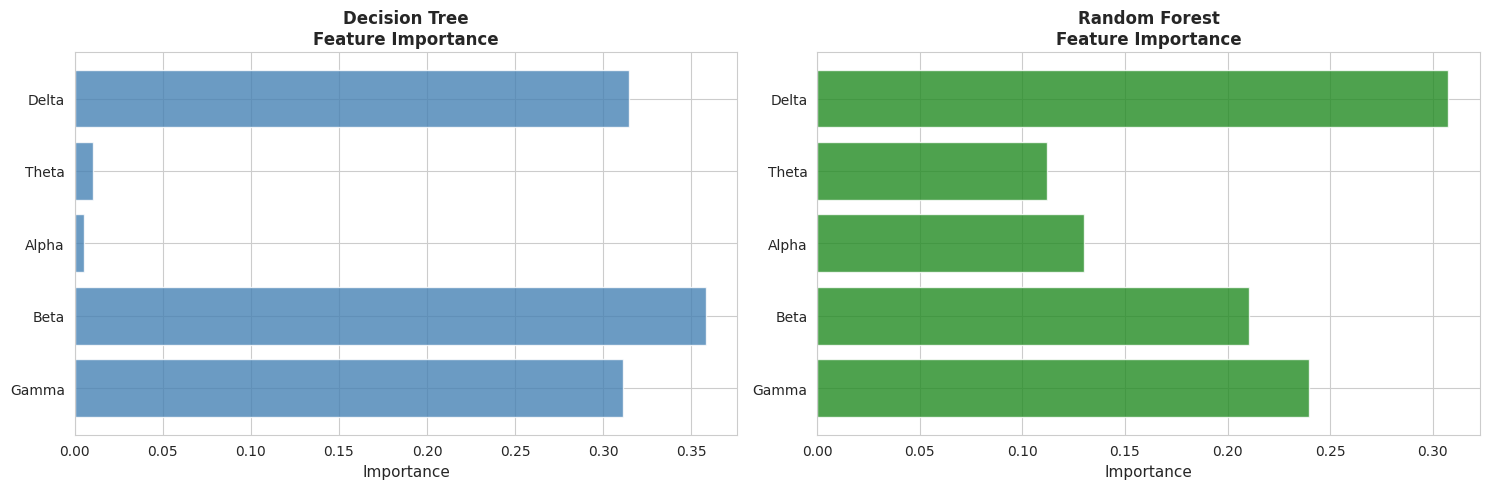


Note: Random Forest importance is averaged across all trees,
making it more stable and reliable than single tree importance.


In [ ]:
# Compare feature importances
rf_feature_importance = rf_classifier.feature_importances_

# Create comparison DataFrame
importance_comparison = pd.DataFrame({
    'Feature': feature_names,
    'Decision Tree': feature_importance,
    'Random Forest': rf_feature_importance
})

print("\nFeature Importance Comparison:")
print(importance_comparison.to_string(index=False))

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.barh(feature_names, feature_importance, color='steelblue', alpha=0.8)
ax1.set_xlabel('Importance', fontsize=11)
ax1.set_title('Decision Tree\nFeature Importance', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

ax2.barh(feature_names, rf_feature_importance, color='forestgreen', alpha=0.8)
ax2.set_xlabel('Importance', fontsize=11)
ax2.set_title('Random Forest\nFeature Importance', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print("\nNote: Random Forest importance is averaged across all trees,")
print("making it more stable and reliable than single tree importance.")

## 5. Multi-Class Classification Metrics

In your previous session, you learned about classification metrics for binary problems. Now let's extend these concepts to multi-class classification, which is what we're dealing with in our EEG mental state classification.

### 5.1 Confusion Matrix for Multi-Class Problems

The confusion matrix is even more informative in multi-class problems. Each row represents the true class, and each column represents the predicted class. The diagonal elements show correct predictions, while off-diagonal elements show misclassifications.

For a 4-class problem like ours, we get a 4×4 matrix showing all possible prediction outcomes.

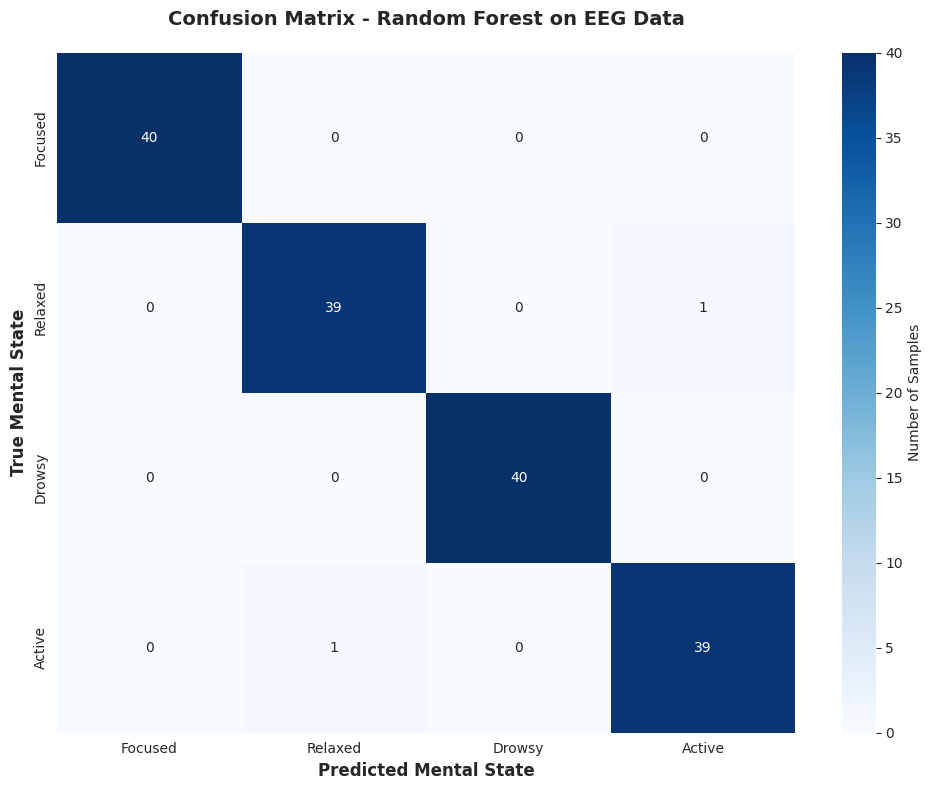

How to interpret the confusion matrix:
- Diagonal elements (dark blue): Correct predictions
- Off-diagonal elements: Misclassifications
- Each row sums to the total number of samples in that true class
- Look for patterns: which classes are confused with each other?


In [ ]:
# Calculate confusion matrix for Random Forest
cm = confusion_matrix(y_test, y_test_pred_rf)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Number of Samples'}
)
plt.ylabel('True Mental State', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Mental State', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Random Forest on EEG Data', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("How to interpret the confusion matrix:")
print("- Diagonal elements (dark blue): Correct predictions")
print("- Off-diagonal elements: Misclassifications")
print("- Each row sums to the total number of samples in that true class")
print("- Look for patterns: which classes are confused with each other?")

### 5.2 Extending Metrics to Multi-Class

For binary classification, you learned about precision, recall, and F1-score. In multi-class problems, we need to extend these metrics. There are several approaches:

#### Accuracy
This one is straightforward - it's the proportion of correct predictions:

$$Accuracy = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$$

#### Per-Class Metrics
We can calculate precision, recall, and F1-score for each class individually by treating it as a "one-vs-all" problem:

**Precision for class $i$**: Of all samples predicted as class $i$, how many were actually class $i$?

$$Precision_i = \frac{TP_i}{TP_i + FP_i}$$

**Recall for class $i$**: Of all samples that are actually class $i$, how many did we predict correctly?

$$Recall_i = \frac{TP_i}{TP_i + FN_i}$$

**F1-Score for class $i$**: Harmonic mean of precision and recall:

$$F1_i = 2 \times \frac{Precision_i \times Recall_i}{Precision_i + Recall_i}$$

#### Averaging Strategies

To get a single metric across all classes, we can use different averaging strategies:

**1. Macro Average**: Calculate metric for each class, then take the unweighted mean
- Treats all classes equally, regardless of their size
- Good when you care equally about all classes

$$Macro\text{-}Average = \frac{1}{C} \sum_{i=1}^{C} Metric_i$$

**2. Weighted Average**: Calculate metric for each class, then take the mean weighted by class size
- Takes class imbalance into account
- Better for imbalanced datasets

$$Weighted\text{-}Average = \sum_{i=1}^{C} \frac{n_i}{N} Metric_i$$

where $n_i$ is the number of samples in class $i$ and $N$ is the total number of samples.

**3. Micro Average** (mainly for precision and recall): Pool all TP, FP, FN across classes and calculate
- In multi-class classification, micro-average equals accuracy

Let's calculate all these metrics!

In [10]:
# Calculate all metrics using sklearn's classification_report
print("="*70)
print("COMPREHENSIVE CLASSIFICATION REPORT - RANDOM FOREST")
print("="*70)
print(classification_report(
    y_test,
    y_test_pred_rf,
    target_names=class_names,
    digits=4
))

print("\nUnderstanding the report:")
print("-" * 70)
print("Per-class metrics (rows 1-4):")
print("  - Precision: When we predict this class, how often are we right?")
print("  - Recall: Of all actual instances of this class, how many did we find?")
print("  - F1-score: Harmonic mean balancing precision and recall")
print("  - Support: Number of actual samples of this class in test set")
print("\nAggregated metrics (last 3 rows):")
print("  - Accuracy: Overall proportion of correct predictions")
print("  - Macro avg: Simple average across classes (treats all equally)")
print("  - Weighted avg: Average weighted by class frequency")
print("="*70)

COMPREHENSIVE CLASSIFICATION REPORT - RANDOM FOREST
              precision    recall  f1-score   support

     Focused     1.0000    1.0000    1.0000        40
     Relaxed     0.9750    0.9750    0.9750        40
      Drowsy     1.0000    1.0000    1.0000        40
      Active     0.9750    0.9750    0.9750        40

    accuracy                         0.9875       160
   macro avg     0.9875    0.9875    0.9875       160
weighted avg     0.9875    0.9875    0.9875       160


Understanding the report:
----------------------------------------------------------------------
Per-class metrics (rows 1-4):
  - Precision: When we predict this class, how often are we right?
  - Recall: Of all actual instances of this class, how many did we find?
  - F1-score: Harmonic mean balancing precision and recall
  - Support: Number of actual samples of this class in test set

Aggregated metrics (last 3 rows):
  - Accuracy: Overall proportion of correct predictions
  - Macro avg: Simple average a

---

## 6. Mini-Project Assignment: DEAP Dataset Arousal Classification

### Objective
Apply the concepts you learned today to classify arousal levels from the DEAP EEG dataset. You will predict four arousal levels: **very low arousal**, **low arousal**, **high arousal**, and **very high arousal**.

### Dataset Information
The DEAP dataset contains EEG recordings from 32 participants watching music videos. Each trial has associated arousal ratings on a scale of 1-9.

### Your Tasks

#### Part 1: Data Preparation
1. Load the DEAP dataset (preprocessed EEG data and labels)
2. Extract relevant features from the EEG data. Consider:
   - Band power features (delta, theta, alpha, beta, gamma) from all channels

3. Create arousal labels by binning the arousal ratings into four categories:
   - Very Low Arousal: ratings 1-3
   - Low Arousal: ratings 4-5
   - High Arousal: ratings 6-7
   - Very High Arousal: ratings 8-9
4. Split your data into training (80%) and testing (20%) sets
5. Document your choices and provide brief justification

#### Part 2: Model Building and Training
1. Build a Decision Tree classifier for arousal prediction
   - Experiment with different hyperparameters (max_depth, min_samples_split, etc.)
   - Explain your choice of hyperparameters
2. Build a Random Forest classifier for arousal prediction
   - Experiment with n_estimators, max_depth, and other parameters
   - Explain your choices
3. Train both models on your training data

#### Part 3: Model Evaluation
1. Evaluate both models on the test set using:
   - Overall accuracy
   - Per-class precision, recall, and F1-score
   - Macro-averaged and weighted-averaged metrics
   - Confusion matrices
2. Visualize:
   - Confusion matrices for both models
   - Per-class performance comparison
   - Feature importance from both models
3. Compare the two models:
   - Which performs better overall?
   - Are there specific arousal levels where one model excels?
   - What do the confusion matrices tell you about common misclassifications?



